# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [0]:
# Downloading the Digital Rock Physics Benchmarks dataset.
!git clone https://github.com/fkrzikalla/drp-benchmarks

# Removing unnecessary files.
!rm -r drp-benchmarks/images/fontainebleau
!rm -r drp-benchmarks/images/spherepack

!rm drp-benchmarks/images/*/segmented-kongju.mat
!rm drp-benchmarks/images/*/segmented-stanford.raw.gz
!rm drp-benchmarks/images/*/segmented-vsg.raw.gz

# Uncompressing raw segmentations.
!gunzip drp-benchmarks/images/berea/segmented-kongju.raw.gz
!gunzip drp-benchmarks/images/grosmont/segmented-kongju.raw.gz

Cloning into 'drp-benchmarks'...
remote: Enumerating objects: 2106, done.
remote: Total 2106 (delta 0), reused 0 (delta 0), pack-reused 2106
Receiving objects: 100% (2106/2106), 4.20 GiB | 35.34 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Checking out files: 100% (2073/2073), done.


In [0]:
# Basic imports.
import gc
import os
import time
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models

from skimage import io
from skimage import transform

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [0]:
# Setting predefined arguments.
args = {
    'epoch_num': 10,      # Number of epochs.
    'dataset': 'berea',   # Dataset.
    'n_classes': 2,       # Number of classes in segmentation task.
    'lr': 1e-4,           # Learning rate.
    'network': 'densenet',    # Network architecture.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 2,     # Number of workers on data loader.
    'batch_size': 8,      # Mini-batch size.
    'crop_size': 256,     # Random crop size.
    'show_freq': 1,       # Frequency for showing predictions.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [0]:
# Random initialization for weights and biases.
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

In [0]:
def evaluate(prds, labs, num_classes):
    
    iou_list = []
    f1_list = []
    
    for prd, lab in zip(prds, labs):
        
        iou = metrics.jaccard_score(lab.ravel(), prd.ravel())
        f1 = metrics.f1_score(lab.ravel(), prd.ravel())
        
        iou_list.append(iou)
        f1_list.append(f1)
        
    iou_list = np.asarray(iou_list)
    f1_list = np.asarray(f1_list)
    
    return iou_list, f1_list

# Dataloaders Customizados

Os frameworks de Deep Learning modernos (i.e. MXNet e Pytorch) permitem a criação de dataloaders customizados ao se sobrescreverem classes desses frameworks. Esse tipo de dataloader é especialmente útil no caso de tarefas diferentes das de classificação que temos visto até agora (i.e. segmentação e detecção de imagens, processamento de áudio, processamento de linguagem, natural, etc), nas quais os labels podem ser mais esparsos ou densos que rótulos de classificação.

Usando como base as classes [*Dataloader*](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) e [*Dataset*](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) do subpacote [*data*](https://pytorch.org/docs/stable/data.html) do Pytorch, podemos customizar a leitura dos dados ao mesmo tempo em que paralelizamos a leitura das amostras dos nossos batches. A paralelização da leitura de amostras em várias [threads](https://www.tutorialspoint.com/python/python_multithreading) torna o uso da GPU o mais eficiente possível, já que não é necessário deixar a GPU esperando pelo carregamento de novas amostras para compor um batch.

In [0]:
# Class that reads the DRP Benchmarks dataset.
class RockDataset(data.Dataset):

    def __init__(self, root, mode, dataset, crop_size=256, num_classes=2):

        # Initializing variables.
        self.root = root
        self.mode = mode
        self.dataset = dataset
        self.crop_size = crop_size
        self.num_classes = num_classes

        # Creating list of image files.
        self.imgs = self.make_dataset()
        
        # Check for consistency in list.
        if len(self.imgs) == 0:

            raise (RuntimeError('Found 0 images, please check the data set.'))

    def make_dataset(self):

        # Joining input paths.
        self.img_path = os.path.join(self.root,
                                     self.dataset,
                                     'tif')
        self.msk_path = os.path.join(self.root,
                                     self.dataset,
                                     'segmented-kongju.raw')
        
        # Preload mask volume.
        transpose_sequence = [0, 2, 1]
        
        if self.mode == 'train':
            self.msk_vol = np.fromfile(open(self.msk_path, 'rb'),
                                       dtype=np.int8).reshape(1024, 1024, 1024)
            self.msk_vol = self.msk_vol.transpose(*transpose_sequence)[:-64]
            
        elif self.mode == 'test':
            self.msk_vol = np.fromfile(open(self.msk_path, 'rb'),
                                       dtype=np.int8).reshape(1024, 1024, 1024)
            self.msk_vol = self.msk_vol.transpose(*transpose_sequence)[-64:]

        # Reading paths from file.
        if self.mode == 'train':
            items = sorted([f for f in os.listdir(self.img_path) if os.path.isfile(os.path.join(self.img_path, f))])[:-64]
        elif self.mode == 'test':
            items = sorted([f for f in os.listdir(self.img_path) if os.path.isfile(os.path.join(self.img_path, f))])[-64:]
            
        # Returning list.
        return items
    
    def __getitem__(self, index):

        # Reading items from list.
        f = self.imgs[index]
        
        img_path = os.path.join(self.img_path, f)
        
        # Reading images.
        img = io.imread(img_path)
        msk = self.msk_vol[index]
        
        # Casting images to the appropriate dtypes.
        img = img.astype(np.float32)
        msk = msk.astype(np.int64)
        
        # Normalization (z-score).
        img = (img - img.mean()) / img.std()

        # Random cropping images.
        if self.mode == 'train':
            
            rand_hw = np.random.randint(0, 1024 - self.crop_size, size=2)

            img = img[rand_hw[0]:(rand_hw[0] + self.crop_size),
                      rand_hw[1]:(rand_hw[1] + self.crop_size)]
            msk = msk[rand_hw[0]:(rand_hw[0] + self.crop_size),
                      rand_hw[1]:(rand_hw[1] + self.crop_size)]
            
            # Fixing channel dimension.
            img = np.expand_dims(img, axis=0) # From (H, W) to (C=1, H, W).

        if self.mode == 'test':
            
            img = [img[0:256, 0:256],    img[256:512, 0:256],    img[512:768, 0:256],    img[768:1024, 0:256],
                   img[0:256, 256:512],  img[256:512, 256:512],  img[512:768, 256:512],  img[768:1024, 256:512],
                   img[0:256, 512:768],  img[256:512, 512:768],  img[512:768, 512:768],  img[768:1024, 512:768],
                   img[0:256, 768:1024], img[256:512, 768:1024], img[512:768, 768:1024], img[768:1024, 768:1024],
                  ]
            msk = [msk[0:256, 0:256],    msk[256:512, 0:256],    msk[512:768, 0:256],    msk[768:1024, 0:256],
                   msk[0:256, 256:512],  msk[256:512, 256:512],  msk[512:768, 256:512],  msk[768:1024, 256:512],
                   msk[0:256, 512:768],  msk[256:512, 512:768],  msk[512:768, 512:768],  msk[768:1024, 512:768],
                   msk[0:256, 768:1024], msk[256:512, 768:1024], msk[512:768, 768:1024], msk[768:1024, 768:1024],
                  ]
            
            img = np.asarray(img, dtype=np.float32)
            msk = np.asarray(msk, dtype=np.int64)
            
        # Turning numpy arrays to tensors.
        img = torch.from_numpy(img)
        msk = torch.from_numpy(msk)

        # Returning to iterator.
        return img, msk

    def __len__(self):

        return len(self.imgs)

gc.collect()

# Instantiating dataloaders.
root = './drp-benchmarks/images/'

# Setting datasets.
train_set = RockDataset(root,
                        'train',
                        args['dataset'],
                        args['crop_size'])
test_set = RockDataset(root,
                       'test',
                       args['dataset'],
                       args['crop_size'])

# Setting dataloaders.
train_loader = DataLoader(train_set,
                          batch_size=args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         batch_size=1,
                         num_workers=args['num_workers'],
                         shuffle=False)

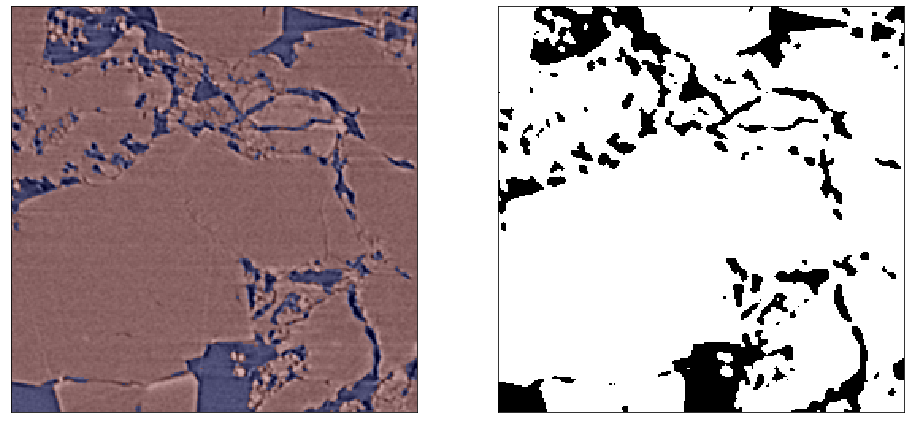

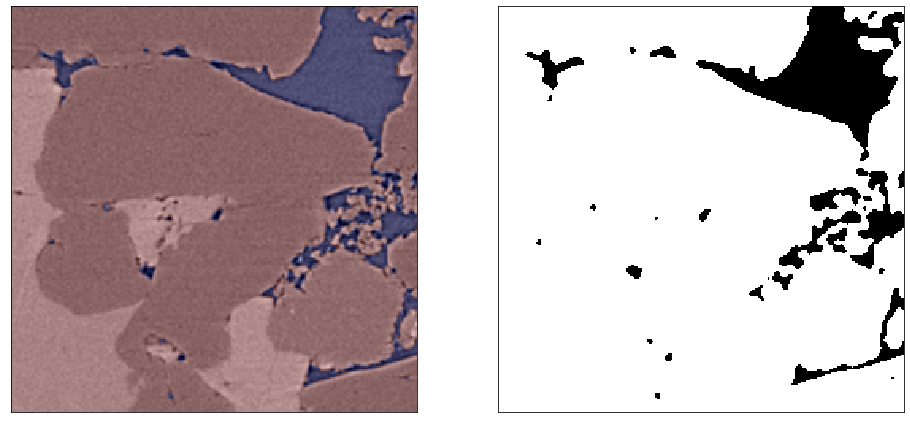

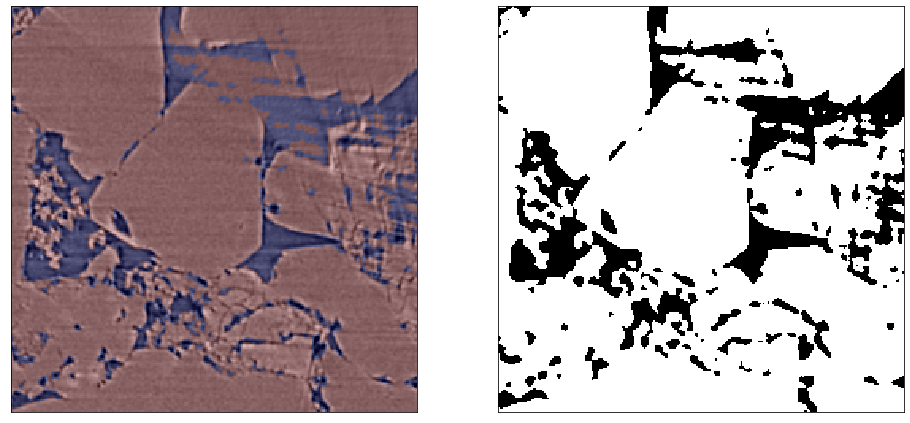

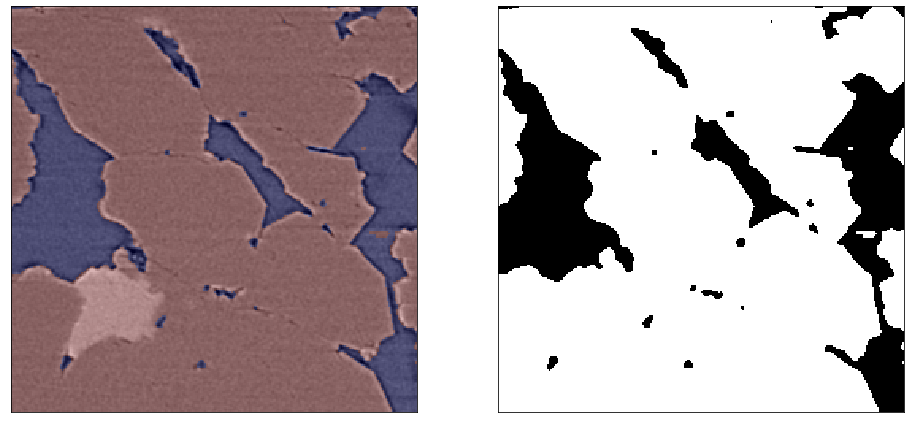

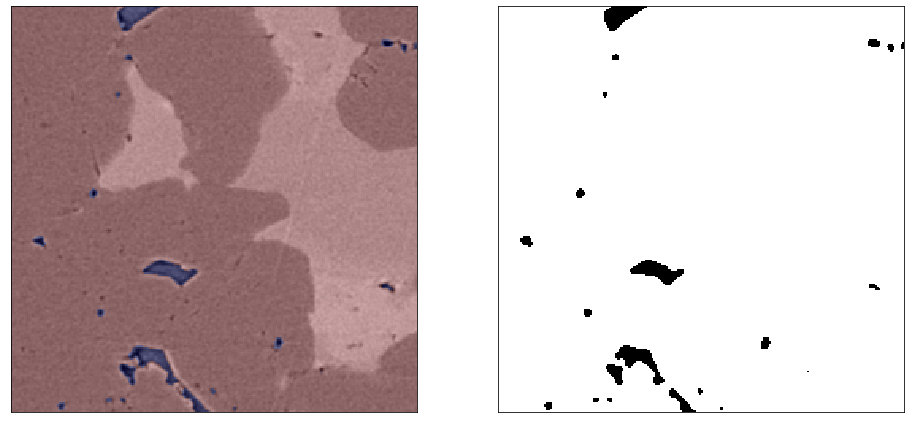

In [0]:
for i, batch_data in enumerate(train_set):
    
    if i > 4:
        break
    
    img, lab = batch_data
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].imshow(img[0].numpy(), cmap=plt.get_cmap('gray'))
    ax[0].imshow(lab.numpy(), 'jet', interpolation='nearest', alpha=0.3) # Uncomment to see overlay of labels.
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    
    ax[1].imshow(lab.numpy(), cmap=plt.get_cmap('gray'))
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    
    plt.show()

# Atividade Prática: Implementando pipeline de segmentação

Usar as arquiteturas de segmentação estudadas durante essa semana e adaptá-la para o dataset de rochas. O dataset contém apenas duas classes e um canal de input, tendo o dataloader já pré-definido a cima. Uma boa ideia é adaptar uma DenseNet como backbone para uma FCN.

Os passos a serem seguidos são os seguintes:

1.   Definir arquitetura de uma rede de segmentação.
2.   Definir uma loss.
3.   Instanciar um otimizador.
4.   Implementar funções de *train()* e *test()*.
5.   Implementar for que itera sobre as epochs.

In [0]:
class EncoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(EncoderBlock, self).__init__()
        
        self.encode = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

    def forward(self, x):
      
      return self.encode(x)


class DecoderBlock(nn.Module):

    def __init__(self, in_channels, middle_channels, out_channels):

        super(DecoderBlock, self).__init__()

        self.decode = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(in_channels, middle_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        )
        

    def forward(self, x):
        
        return self.decode(x)
      
      
class Conv2dBlock(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(Conv2dBlock, self).__init__()
        
        self.convBlock = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        
        return self.convBlock(x)
      
class Conv2dBlockFinal(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(Conv2dBlockFinal, self).__init__()
        
        self.convBlockFinal = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        )

    def forward(self, x):
        
        return self.convBlockFinal(x)


class UNet(nn.Module):

    def __init__(self, input_channels, num_classes):

        super(UNet, self).__init__()

        # TO DO: this U-Net will be composed of 4 Encoder Blocks and 4
        #        Decoder Blocks:
        #        1) Encoder Block inputting input_channels and outputting 64
        #           channels;
        #        2) Encoder Block outputting 128 channels;
        #        3) Encoder Block 256 channels;
        #        4) Encoder Block outputting 512 channels;
        #        5) Decoder Block inputting 512 channels, 1024 middle channels
        #           and outputting 512 channels;
        #        6) Decoder Block inputting 1024 channels, 512 middle channels
        #           and outputting 256 channels;
        #        7) Decoder Block inputting 512 channels, 256 middle channels
        #           and outputting 128 channels;
        #        8) Decoder Block inputting 256 channels, 128 middle channels
        #           and outputting 64 channels;
        #        9) 2d conv block (conv + batch norm + ReLU) outputting 64
        #           channels;
        #        10) 2d conv block (conv + batch norm + ReLU) outputting 64
        #            channels;
        #        11) 2d conv block with kernel 1x1 outputting num_classes
        #            channels. This is the pixel classification layer.
        
        self.enc1 = EncoderBlock(input_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        
        self.center = DecoderBlock(512, 1024, 512)
        self.dec4 = DecoderBlock(1024, 512, 256)
        self.dec3 = DecoderBlock(512, 256, 128)
        self.dec2 = DecoderBlock(256, 128, 64)
        self.dec1 = Conv2dBlock(64, 64)

        self.final = Conv2dBlockFinal(64, num_classes)

        # Random initialization for weights.
        initialize_weights(self)

    def forward(self, x):

        # TO DO: implement forward on Encoder Blocks.
        enc1_out = self.enc1(x)
        enc2_out = self.enc2(enc1_out)
        enc3_out = self.enc3(enc2_out)
        enc4_out = self.enc4(enc3_out)

        # TO DO: implement forward on Decoder Blocks. Each Decoder receives the
        #        output of the last layer concatenated with the output of an
        #        Encoder Block with compatible size. See U-Net architectural
        #        scheme above.
        
        center_out = self.center(enc4_out)
        
        #dec4_out = self.dec4(torch.cat([center_out, F.upsample(enc4_out, center_out.size()[2:], mode='bilinear')], 1))
        
        dec4_in = torch.cat([center_out, F.upsample(enc4_out, center_out.size()[2:])], 1)
        
        dec4_out = self.dec4(dec4_in)
        
        dec3_in = torch.cat([dec4_out, F.upsample(enc3_out, dec4_out.size()[2:])], 1)
        
        dec3_out = self.dec3(dec3_in)
        
        dec2_in = torch.cat([dec3_out, F.upsample(enc2_out, dec3_out.size()[2:])], 1)
        
        dec2_out =  self.dec2(dec2_in)
        
        dec1_in = torch.cat([dec2_out, F.upsample(enc1_out, dec2_out.size()[2:])], 1)
        
        # TO DO: implement forward on the final 2 conv blocks and final 1x1
        #        conv to predict classes.
        dec1_out = self.dec1(dec2_out)

        final_out = self.final(dec1_out)

        # TO DO: return output.
        return final_out


net = UNet(1, num_classes=args['n_classes']).to(args['device'])

In [0]:
#definindo a loss

criterion = nn.CrossEntropyLoss().to(args['device'])

In [0]:
#definindo o otimizador

optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

In [0]:
# Training function.
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Average Meter for batch loss.
    train_loss = []

    # Lists for whole epoch loss.
    labs_all, prds_all = [], []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs = net(inps)
        
        # Computing loss.
        loss = criterion(outs, labs)

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()
        
        # Appending images for epoch loss calculation.
        labs_all.append(labs.detach().data.squeeze(0).cpu().numpy())
        prds_all.append(prds)
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    iou, f1 = evaluate(prds_all, labs_all, args['n_classes'])

    # Printing training epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [iou %.4f +/- %.4f], [f1 %.4f +/- %.4f], [time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), iou.mean(), iou.std(), f1.mean(), f1.std(), (toc - tic)))
    print('-------------------------------------------------------------------')
    

def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode.
    net.eval()

    # Average Meter for batch loss.
    test_loss = []

    # Lists for whole epoch loss.
    labs_all, prds_all = [], []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)
        
        # Obtaining predictions.
        prds = outs.data.max(1)[1].squeeze_(1).squeeze(0).cpu().numpy()
        
        # Updating lists.
        test_loss.append(loss.data.item())
        prds_all.append(prds)
        labs_all.append(labs.detach().data.squeeze(0).cpu().numpy())
    
    toc = time.time()
    
    
    test_loss = np.asarray(test_loss)
    
    # Computing error metrics for whole epoch.
    iou, f1 = evaluate(prds_all, labs_all, args['n_classes'])

    # Printing test epoch loss and metrics.
    print('-------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [iou %.4f +/- %.4f], [f1 %.4f +/- %.4f], [time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), iou.mean(), iou.std(), f1.mean(), f1.std(), (toc - tic)))
    print('-------------------------------------------------------------------')

In [0]:
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion, epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


-------------------------------------------------------------------
[epoch 1], [train loss 0.0467 +/- 0.0072], [iou 0.9823 +/- 0.0037], [f1 0.9911 +/- 0.0019], [time 129.23]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 1], [test loss 0.0341 +/- 0.0037], [iou 0.9878 +/- 0.0023], [f1 0.9938 +/- 0.0012], [time 46.38]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [train loss 0.0395 +/- 0.0063], [iou 0.9844 +/- 0.0036], [f1 0.9922 +/- 0.0018], [time 128.98]
-------------------------------------------------------------------
-------------------------------------------------------------------
[epoch 2], [test loss 0.0374 +/- 0.0044], [iou 0.9839 +/- 0.0026], [f1 0.9919 +/- 0.0013], [time 46.40]
-------------------------------------------------------------------
------------------------------------